First, the data is read and examined briefly.

In [147]:
import pandas as pd
data = pd.read_csv("ERIC-B-2012-01-01-2021-12-24.csv", sep=";", decimal = ',')
data.head()

,Date,Bid,Ask,Opening price,High price,Low price,Closing price,Average price,Total volume,Turnover,Trades
0,2021-12-23,98.59,98.60,97.98,98.93,97.70,98.60,98.504,5284913.0,5.205748e+08,7194
1,2021-12-22,96.86,96.90,97.45,97.78,96.45,97.13,97.061,4462309.0,4.330978e+08,6507
2,2021-12-21,97.27,97.30,96.38,97.46,95.95,97.46,97.053,4926638.0,4.781271e+08,7853
3,2021-12-20,95.84,95.88,96.00,96.55,95.03,96.03,95.985,5853032.0,5.618454e+08,8824
4,2021-12-17,96.69,96.72,96.08,96.96,94.85,96.96,96.376,13979148.0,1.347208e+09,14566


In [148]:
data.isnull().sum() # number of missing values in each column

Date             0
Bid              1
Ask              1
Opening price    2
High price       2
Low price        2
Closing price    0
Average price    2
Total volume     2
Turnover         2
Trades           0
dtype: int64

The data contains only a few missing values and they can easily be filled in with data from the previous day, without affecting the predictions.

In [149]:
data.fillna(method='ffill', inplace=True)

To simplify the calculations, the Closing price is chosen to represent the daily stock price. The data must be scaled in a range from 0 to 1 to improve the possibilities to get the desired result, and the data is split in training and test data to make sure that the evaluation of the model is done on unseen data.

In [150]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(np.array(data['Closing price']).reshape(-1, 1))
size = len(scaled_data)
scaled_train = scaled_data[:int(size * 0.75)]
scaled_test = scaled_data[int(size * 0.75):]

The data is looped through to create a dataset consisting of multiple arrays, where each array consists of a number of days' closing prices, preceding the stock price that will be predicted.

In [151]:
preceding_days = 100
def create_dataset(x_data, days = 60):
    X_out = []
    y_out = []
    for i in range(days, len(x_data)):
        X_out.append(x_data[i-days:i, 0])
        y_out.append(x_data[i, 0])
    X_out = np.array(X_out)
    y_out = np.array(y_out)
    X_out = np.reshape(X_out, (X_out.shape[0], X_out.shape[1], 1))
    return X_out, y_out
X_train, y_train = create_dataset(scaled_train, preceding_days)
X_test, y_test = create_dataset(scaled_test, preceding_days)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1779, 100, 1) (1779,)
(527, 100, 1) (527,)


The Tensorflow Keras sequential LSTM model is created.

In [152]:
import tensorflow as tf
nodes_per_layer = 50
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = nodes_per_layer, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = nodes_per_layer, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = nodes_per_layer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_34 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_35 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_35 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_36 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_36 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

The model is compiled and trained with the training data.

In [153]:
epochs = 300
batch_size = 64
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
28/28 [==============================] - 39s 339ms/step - loss: 0.0371 - mean_squared_error: 0.0371
Epoch 2/50
28/28 [==============================] - 6s 203ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/50
28/28 [==============================] - 5s 164ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 4/50
28/28 [==============================] - 5s 165ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 5/50
28/28 [==============================] - 5s 168ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 6/50
28/28 [==============================] - 5s 166ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/50
28/28 [==============================] - 5s 184ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 8/50
28/28 [==============================] - 6s 207ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 9/50
28/28 [==============================] - 6s 210ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/

The Mean Squared Error for each epoch is plotted and the trend line shows that the model performs better the more epochs are run.

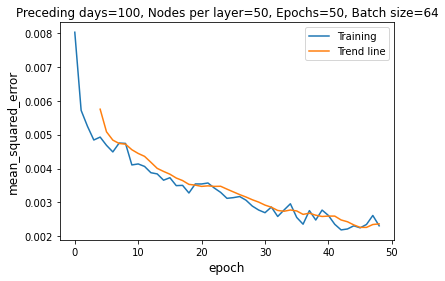

In [158]:
import matplotlib.pyplot as plt
metric = "mean_squared_error"
plt.figure()
plt.plot(history.history[metric][1:]) # Skip the first value to make the plot easier to read. 
plt.plot(pd.Series(history.history[metric][1:]).rolling(epochs//10).mean()) # Trend line
plt.title("Preceding days={}, Nodes per layer={}, Epochs={}, Batch size={}".format(preceding_days, nodes_per_layer, epochs, batch_size))  
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["Training", "Trend line"], loc="best")
plt.show()
plt.close()

The model is used to predict closing prices from the test data and the predictions are scaled back to closing prices.

In [155]:
y_pred = model.predict(X_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)
y_pred_unscaled[:5]

array([[80.32535 ],
       [80.175705],
       [80.08563 ],
       [79.84415 ],
       [79.500404]], dtype=float32)

The predictions are plotted together with the actual closing prices for the same period.

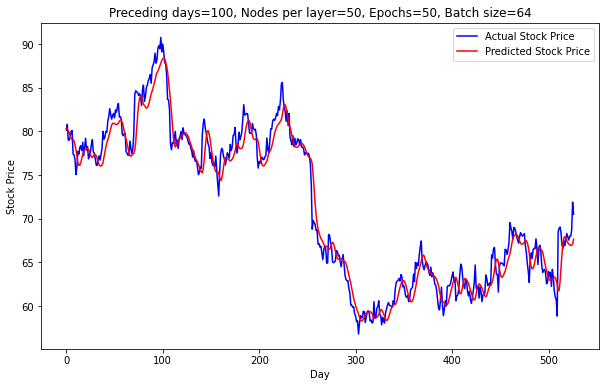

In [156]:
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10,6))  
plt.plot(y_test_unscaled, color='blue', label='Actual Stock Price')  
plt.plot(y_pred_unscaled , color='red', label='Predicted Stock Price')  
plt.title("Preceding days={}, Nodes per layer={}, Epochs={}, Batch size={}".format(preceding_days, nodes_per_layer, epochs, batch_size))  
plt.xlabel('Day')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  

The overall Mean Squared Error is calculated as a metric for the model performance.

In [157]:
metrics = tf.keras.metrics.MeanSquaredError()
metrics.update_state(y_pred_unscaled, y_test_unscaled)
print("Preceding days={}, Nodes per layer={}, Epochs={}, Batch size={}".format(preceding_days, nodes_per_layer, epochs, batch_size))
print("The mean squared error is {}".format(metrics.result().numpy()))


Preceding days=100, Nodes per layer=50, Epochs=50, Batch size=64
The mean squared error is 2.971235752105713
